# Estimate harmonics using least-squares and covariance parameters using speccy+MLE



In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import arviz as az
import corner

In [2]:
import nwatides
from nwatides.hanalysis import least_square
from nwatides.hamcmcjax import *
from nwatides import scoring

In [3]:
plt.rcParams['font.size']=14
plt.rcParams['axes.labelsize']='medium'
plt.rcParams['pcolor.shading']='auto'

## Load the pre-computed velocity data

See: `../../SWOT_NAust/NOTEBOOKS/calc_steric_height_moorings.ipynb`

In [4]:
sitename = 'NWSBRW'
t1,t2 = None, None
# sitename = 'NWSBAR'
# t1,t2 = '2022-05-12 00:00:00', '2022-09-12 00:00:00'
ds = xr.open_dataset('../DATA/IMOS_{}_202205_202210_uv.nc'.format(sitename)).sel(TIME=slice(t1,t2))
ds2 = xr.open_dataset('../DATA/IMOS_{}_202210_202305_uv.nc'.format(sitename))


## Change these



In [5]:
ds

<xarray.Dataset>
Dimensions:              (TIME: 24960)
Coordinates:
  * TIME                 (TIME) datetime64[ns] 2021-11-12T02:09:53.001101824 ...
    HEIGHT_ABOVE_SENSOR  float32 ...
    LATITUDE             float64 ...
    LONGITUDE            float64 ...
    NOMINAL_DEPTH        float32 ...
Data variables:
    UCUR                 (TIME) float32 ...
    VCUR                 (TIME) float32 ...
Attributes:
    ancillary_variables:         UCUR_quality_control
    comment:                     magneticDeclinationPP: data initially referr...
    compass_correction_applied:  1.55
    long_name:                   eastward_sea_water_velocity
    magnetic_declination:        1.55
    reference_datum:             true north
    standard_name:               eastward_sea_water_velocity
    units:                       m s-1
    valid_max:                   10.0
    valid_min:                   -10.0

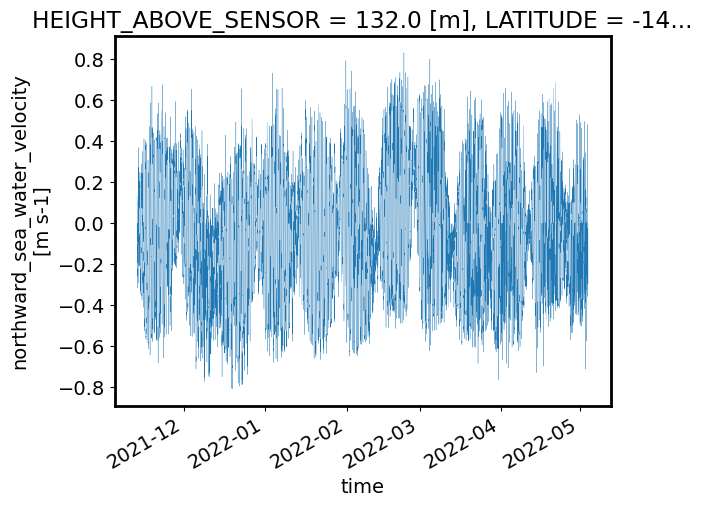

In [6]:
ds['VCUR'].plot(lw=0.2)

In [7]:
# tidal arguments (equilibrium phase, nodal corrections ...)
#ar['omega'].sel(constituents='m2')

In [8]:
# constituents = ['m2','s2','k1','o1']
# constituents = None

constituents = ['m2','s2','n2','k2','k1','o1','p1','q1']

omega_M2 = 2*np.pi/0.00014052/86400
omega_S2 = 0.5

omega_A = 2*np.pi/365.25

constituents += [omega_M2-omega_A, omega_M2+omega_A,
                 omega_M2-2*omega_A, omega_M2+2*omega_A,
                omega_S2-omega_A, omega_S2+omega_A,
                 omega_S2-2*omega_A, omega_S2+2*omega_A]

nanidx = ~np.isnan(ds['VCUR'].values)
y = ds['VCUR'].values[nanidx]
t = ds['TIME'].values[nanidx]

ar = nwatides.get_tidal_arguments(t)
if constituents is None:
    constituents=ar.constituents.values

ha = least_square(y, t, constituents)
ha

<xarray.Dataset>
Dimensions:      (c: 16, time: 24686)
Coordinates:
  * c            (c) <U32 'm2' 's2' ... '0.534404847677917'
  * time         (time) datetime64[ns] 2021-11-13T01:09:53.001095168 ... 2022...
Data variables:
    h_real       (c) float64 -0.0001305 0.05396 -0.02729 ... -0.003393 -0.08537
    h_imag       (c) float64 -0.001741 -0.1135 0.1224 ... -0.001818 0.1568
    h_real_var   (c) float64 2.708e-06 0.00029 0.0002899 ... 2.098e-06 2.623e-06
    h_imag_var   (c) float64 2.707e-06 0.0002887 ... 2.109e-06 2.614e-06
    h            (time) float32 0.1304 0.07558 0.07552 ... -0.2234 -0.2966 0.0
    h_predicted  (time) float64 0.1621 0.1529 0.1428 ... -0.4177 -0.4056 -0.3906
    h_residual   (time) float64 -0.03172 -0.07736 -0.06728 ... 0.109 0.3906

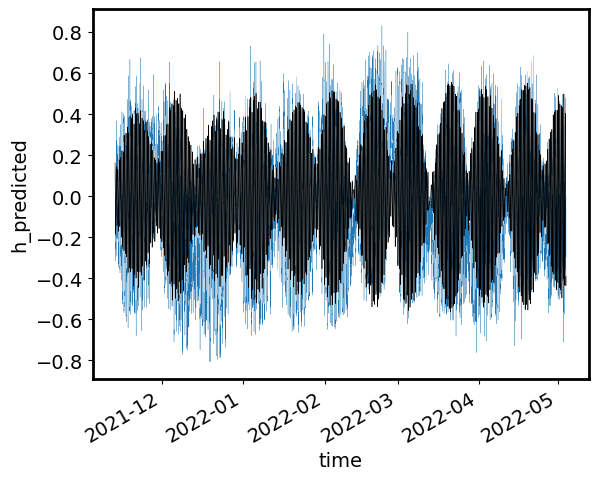

In [9]:
plt.figure()
ha['h'].plot(lw=0.2)
ha['h_predicted'].plot(c='k',lw=0.4)

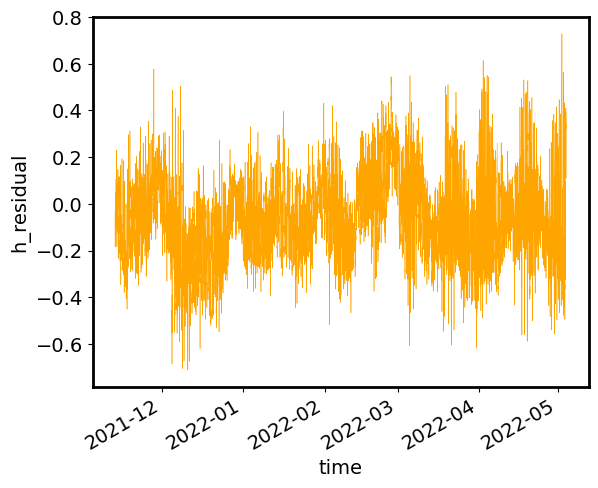

In [10]:
plt.figure()
#(ha['h']-ha['h_predicted']).plot(lw=0.2)
ha['h_residual'].plot(c='orange',lw=0.4)

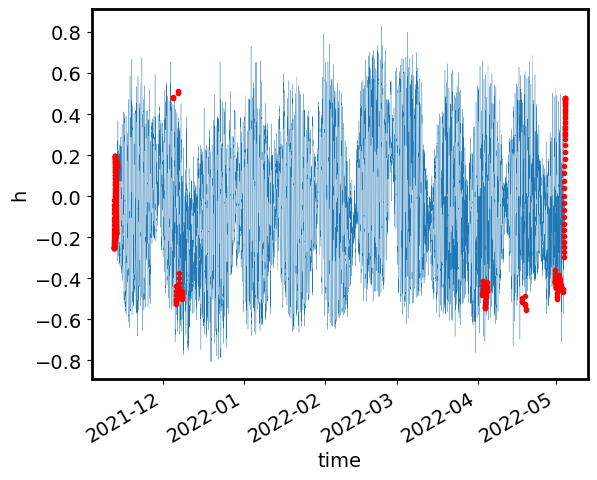

In [11]:
# Fill in the gaps using the harmonics
tgaps = ds['TIME'].values[~nanidx]
ygaps = harmonic_mean_tmd(tgaps[:,None], 
        np.hstack([ha['h_real'].values,ha['h_imag'].values]),
        constituents=constituents)

plt.figure()
ha['h'].plot(lw=0.2)
plt.plot(tgaps, ygaps,'r.')

In [12]:
y_ = ds['VCUR'].values
t_ = ds['TIME'].values

y_[~nanidx] = ygaps[:,0]

ha_ = least_square(y_, t_, constituents)

In [13]:
import nwatides.nonstat_itides_jax as nsjax

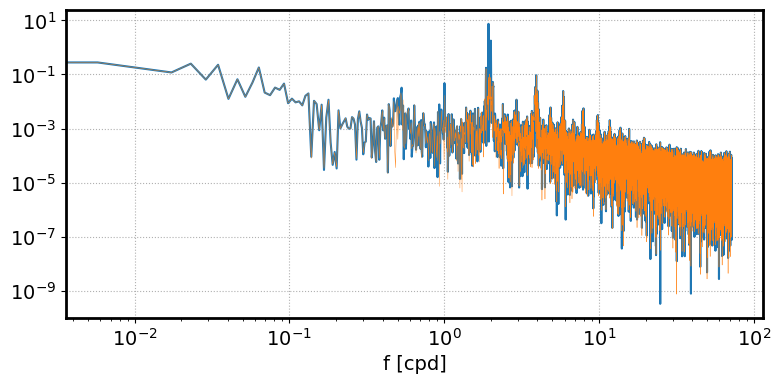

In [14]:
# Speccy the residual
X=t_.astype(float)/1e9/86400. # Days

dt = X[1]-X[0]
# y = ha['h_residual']

f, I = nsjax.periodogram(ha_['h'].values, dt)
f, I2 = nsjax.periodogram(ha_['h_residual'].values, dt)

# acf = covfunc(X, X[0], params[ii,:].values, **cov_kwargs)
# f_S, S = nsjax.bochner(acf, delta=dt)

plt.figure(figsize=(9,4))
# ax1=plt.subplot(121)
plt.loglog(f, 2*I)
plt.loglog(f, 2*I2, lw=0.3)

# plt.loglog(f_S,S)
# plt.loglog(f_S,Si,':')
# plt.xlim(fmin, fmax)
plt.xlabel('f [cpd]')
plt.grid(True, ls=':')

In [15]:
# covfunc=nsjax.itide_meso_nof_gammaexp
# covlabels = ['η_m','τ_m','γ_m','η_D2','τ_D2','η_D1','τ_D1']
# covparams = (0.1, 7, 1.5, 0.01, 7, 0.01, 7)

covfunc=nsjax.itide_fD2D1_meso_gammaexp
covfunc_gp = itide_fD2D1_meso_gammaexp_t
covparams = (0.1, 7, 1.5, 0.01, 7, 0.01, 7, 0.01, 7)
covlabels = ['η_m','τ_m','γ_m','η_f','τ_f','η_D2','τ_D2','η_D1','τ_D1']

fmin = 1e-3 #0.7
fmax = 2.5 #


# covfunc=nsjax.itide_fD2D1D4_meso_gammaexp
# covfunc_gp = nsjax.itide_fD2D1D4_meso_gammaexp_t

# covparams = (0.1, 7, 1.5, 0.01, 7, 0.01, 7, 0.01, 7, 0.01, 7)
# covlabels = ['η_m','τ_m','γ_m','η_f','τ_f','η_D2','τ_D2','η_D1','τ_D1','η_D4','τ_D4']
# fmax = 5 #

covfunc=nsjax.meso_D2_periodic
covfunc_gp = nsjax.meso_D2_periodic_t

covparams = (0.1, 7, 1.0, 0.01, 2., 0.5, 0.1, 0.1, 7.)
covlabels = ['η_m','τ_m','γ_m','η_iw','τ_iw','γ_iw','η_D2','l_D2','τ_D2']
fmax = 30 #



In [16]:
import optax

In [17]:
%%time
params, loss_val = nsjax.estimate_jax(ha_['h_residual'].values, X,
                     covfunc, covparams, fmin, fmax,
                      maxiter=5000,
                     opt= optax.adabelief(learning_rate=1e-2),
                     #opt= optax.sgd(learning_rate=3e-4),
                    #transformer=LogTransformer,
                     verbose=True)

step 0, loss: 57135.7934831017
[0.10100502 6.93034884 0.99004983 0.0101005  1.98009967 0.49502492
 0.10100502 0.10100502 6.93034884]
step 25, loss: -67811.5320861604
[0.1410728  5.05549478 0.72386979 0.01327649 1.52999522 0.38262398
 0.1329312  0.11367627 5.23510988]
step 50, loss: -82830.64975991484
[0.17681442 4.23611119 0.61074545 0.01459577 1.41497314 0.35455258
 0.14577067 0.11446769 4.73144044]
step 75, loss: -84830.35137171559
[0.19701071 3.94151638 0.57127003 0.01492341 1.39186249 0.34914521
 0.14744661 0.11957962 4.64976355]
step 100, loss: -85362.9192755046
[0.20834182 3.80862848 0.55358724 0.01502599 1.38527378 0.34767222
 0.14608868 0.12842566 4.66869799]
step 125, loss: -85683.57598309153
[0.21482359 3.73896993 0.54405789 0.01507019 1.3825056  0.3470704
 0.1437459  0.14281344 4.71894759]
step 150, loss: -86088.43921129117
[0.21852063 3.69947673 0.53820501 0.01509365 1.38101598 0.34674248
 0.14102501 0.16730947 4.77997002]
step 175, loss: -86754.63756372019
[0.22084464 3.67

In [18]:
print(''.join('{} | '.format(k) for k in covlabels))
print(''.join('{:3.4f} | '.format(k) for k in params))

η_m | τ_m | γ_m | η_iw | τ_iw | γ_iw | η_D2 | l_D2 | τ_D2 | 
0.1745 | 3.0361 | 0.4038 | 0.0152 | 1.3496 | 0.3540 | 0.1071 | 0.4913 | 3.5171 | 


(1e-08, 10.0)

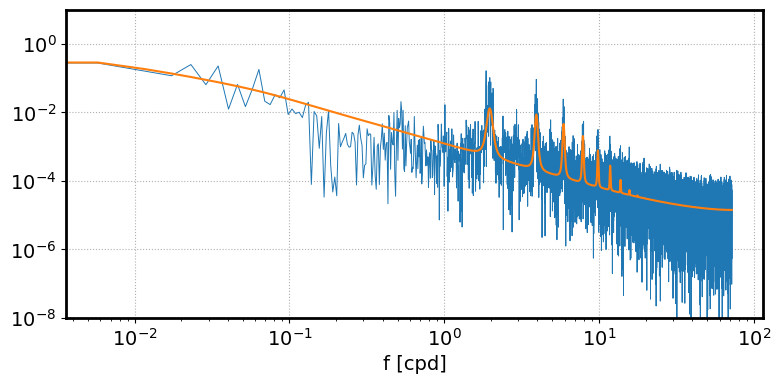

In [19]:
acf = covfunc(X, X[0], params, )
f_S, S = nsjax.bochner(acf, delta=dt)

plt.figure(figsize=(9,4))
# ax1=plt.subplot(121)
# plt.loglog(f, 2*I)
plt.loglog(f, 2*I2, lw=0.7)

plt.loglog(f_S,S)
#plt.xlim(fmin, fmax)
# plt.xlim(1, 5)
plt.xlabel('f [cpd]')
plt.grid(True, ls=':')
plt.ylim(1e-8, 1e1)
# plt.title(sites[sitenum])

# Use a GP to make a prediction

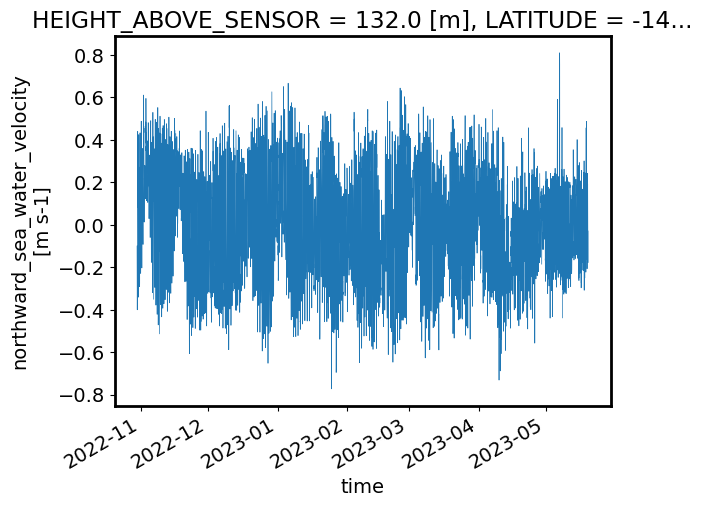

In [20]:
ds2['VCUR'].plot(lw=0.5)

In [21]:
ds_train = ds2['VCUR'].sel(TIME=slice('2022-11-01 00:00:00','2022-11-15 00:00:00')).\
    isel(TIME=slice(None,None,1)) # Hourly data

ds_test= ds2['VCUR'].sel(TIME=slice('2022-11-15 00:00:00','2022-11-22 00:00:00')).\
    isel(TIME=slice(None,None,1)) # Hourly data

In [22]:

noise = 0.01 # Guess
covparams = params
# covparams = covparams.at[0].set(0.0) # Wipe out mesoscale
meanfunc = harmonic_mean_tmd
meanparams =np.hstack([ha['h_real'].values,ha['h_imag'].values])
nsamples = 50

x = ds_train.TIME.values
xout = ds_test.TIME.values
GP = gpjax.GPtideJax(x[:,None], xout[:,None], 
                noise, 
                covfunc_gp,
                covparams,
                mean_func=meanfunc, 
                mean_params=meanparams,
                mean_kwargs=dict(constituents=constituents),
                    )

y_pred = GP(ds_train.values[:,None])
y_cond = GP.conditional(ds_train.values[:,None], samples=nsamples)

(-1.0, 1.0)

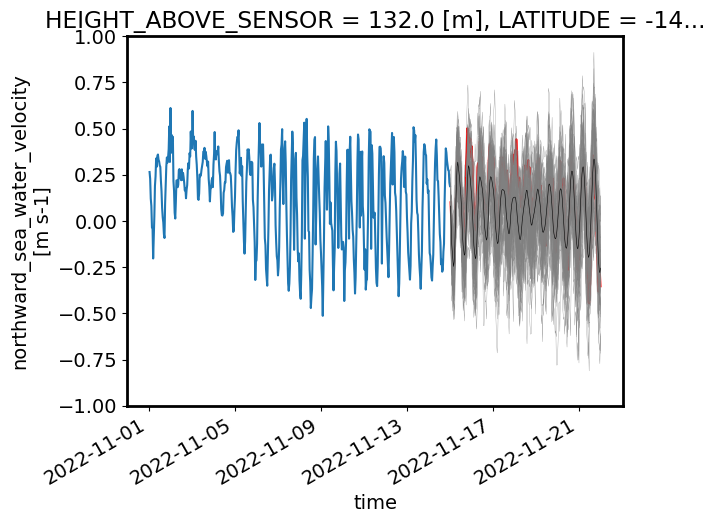

In [23]:
plt.figure()
ds_train.plot()
ds_test.plot(c='r')
for ii in range(nsamples):
    plt.plot(xout, y_cond[:,ii], lw=0.2, c='0.5')
plt.plot(xout, y_pred[:,0], lw=0.4, c='k')
plt.ylim(-1,1)

Text(0.5, 1.0, '')

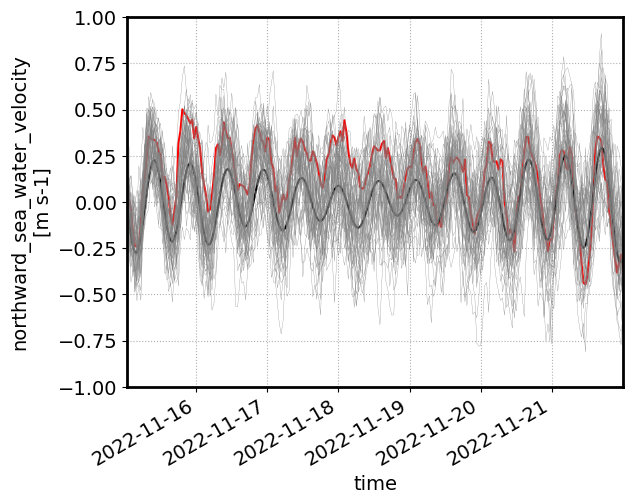

In [24]:
plt.figure()
ds_test.plot(c='r')
plt.plot(xout, GP.mu_m,'k')
for ii in range(nsamples):
    plt.plot(xout, y_cond[:,ii], lw=0.2, c='0.5')
# plt.plot(xout, y_pred[:,0], lw=0.4, c='k')
plt.ylim(-1,1)
plt.grid(True, ls=':')
plt.xlim(xout[0], xout[-1])
plt.title('')

(-1.0, 1.0)

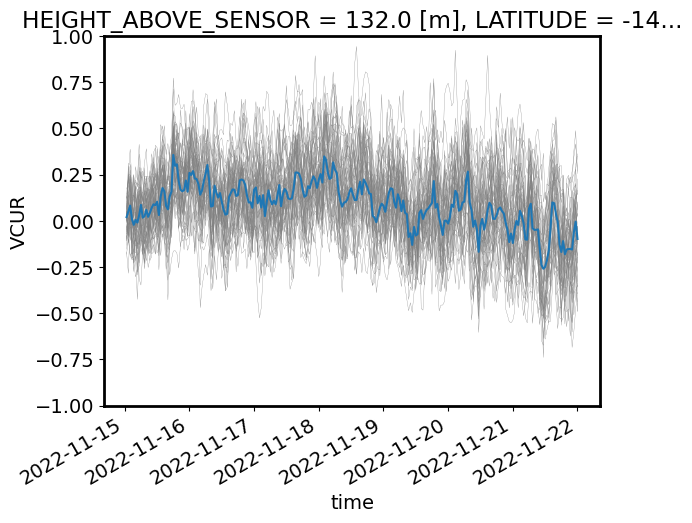

In [25]:
plt.figure()
for ii in range(nsamples):
    plt.plot(xout,ds_test-y_cond[:,ii], lw=0.2, c='0.5')

(ds_test - y_pred[:,0]).plot()

plt.ylim(-1,1)

In [26]:
scoring.calc_CRPS(ds_test.values, y_cond.T)

0.08830222185826793

In [27]:
rmse = np.sqrt(np.mean((ds_test.values - y_pred[:,0])**2))
rmse

Array(0.14424372, dtype=float64)

In [28]:
def calc_predictive_skill(ds_train, ds_test, 
                noise, 
                covfunc_gp,
                covparams,
                meanfunc, 
                meanparams,
                mean_kwargs,
                nsamples=50):

    x = ds_train.TIME.values
    xout = ds_test.TIME.values
    
    idx = ~onp.isnan(ds_train.values)
    ytrain = ds_train.values[idx,None]
    ytest = ds_test.values[:,None]
    
    GP = gpjax.GPtideJax(x[idx][:,None], xout[:,None], 
                    noise, 
                    covfunc_gp,
                    covparams,
                    mean_func=meanfunc, 
                    mean_params=meanparams,
                    mean_kwargs=mean_kwargs,
                        )
    
    y_pred = GP(ytrain)
    y_cond = GP.conditional(ytrain, samples=nsamples)

    crps = scoring.calc_CRPS(ytest, y_cond.T)
    rmse = np.sqrt(np.mean((ytest - y_pred)**2))
    rmse_mu = np.sqrt(np.mean((ytest - GP.mu_m)**2))
    return GP, y_pred, y_cond, crps, rmse, rmse_mu

def calc_mean_params(ds_train, constituents):
    
    nanidx = ~np.isnan(ds_train.values)
    y = ds_train.values[nanidx]
    t = ds_train.TIME.values[nanidx]
    
    ha = least_square(y, t, constituents)   

    return np.hstack([ha['h_real'].values,ha['h_imag'].values])

In [29]:
def plot_conditional(ds_train, ds_test, GP, y_pred, y_cond):
    xout = GP.xm
    fig = plt.figure()
    ds_train.plot()
    ds_test.plot(c='r')
    for ii in range(nsamples):
        plt.plot(xout, y_cond[:,ii], lw=0.2, c='0.5', alpha=0.2)
    plt.plot(xout, y_pred[:,0], lw=0.4, c='k')
    plt.ylim(-1,1)
    plt.title('')
    plt.xlim(GP.xd[0,0],xout[-1,0])
    plt.grid(True, ls=':')

We want to use:
- 14 d blocks of training data
- Move forward 7 d (50 % overlap in window)
- Predictive skill for 0.5, 1, 2, 3, 5, 7 d forecasts windows

In [30]:
t1,t2 = '2022-11-01 00:00:00', '2023-05-01 00:00:00'

times = xr.date_range(t1,t2, freq='7D')
start_times = times[0:-2]
end_times = times[2::]

forecast_times = [onp.timedelta64(int(ii*86400),'s') for ii in [ 0.5, 1., 2., 3., 5. ,7.]]

start_times, end_times, forecast_times

(DatetimeIndex(['2022-11-01', '2022-11-08', '2022-11-15', '2022-11-22',
                '2022-11-29', '2022-12-06', '2022-12-13', '2022-12-20',
                '2022-12-27', '2023-01-03', '2023-01-10', '2023-01-17',
                '2023-01-24', '2023-01-31', '2023-02-07', '2023-02-14',
                '2023-02-21', '2023-02-28', '2023-03-07', '2023-03-14',
                '2023-03-21', '2023-03-28', '2023-04-04', '2023-04-11'],
               dtype='datetime64[ns]', freq='7D'),
 DatetimeIndex(['2022-11-15', '2022-11-22', '2022-11-29', '2022-12-06',
                '2022-12-13', '2022-12-20', '2022-12-27', '2023-01-03',
                '2023-01-10', '2023-01-17', '2023-01-24', '2023-01-31',
                '2023-02-07', '2023-02-14', '2023-02-21', '2023-02-28',
                '2023-03-07', '2023-03-14', '2023-03-21', '2023-03-28',
                '2023-04-04', '2023-04-11', '2023-04-18', '2023-04-25'],
               dtype='datetime64[ns]', freq='7D'),
 [numpy.timedelta64(43200,'s'),


In [31]:
M, N = start_times.shape[0], len(forecast_times)

2022-11-01 00:00:00 2022-11-15 00:00:00
2022-11-08 00:00:00 2022-11-22 00:00:00
2022-11-15 00:00:00 2022-11-29 00:00:00
2022-11-22 00:00:00 2022-12-06 00:00:00
2022-11-29 00:00:00 2022-12-13 00:00:00
2022-12-06 00:00:00 2022-12-20 00:00:00
2022-12-13 00:00:00 2022-12-27 00:00:00
2022-12-20 00:00:00 2023-01-03 00:00:00
2022-12-27 00:00:00 2023-01-10 00:00:00
2023-01-03 00:00:00 2023-01-17 00:00:00
2023-01-10 00:00:00 2023-01-24 00:00:00
2023-01-17 00:00:00 2023-01-31 00:00:00
2023-01-24 00:00:00 2023-02-07 00:00:00
2023-01-31 00:00:00 2023-02-14 00:00:00
2023-02-07 00:00:00 2023-02-21 00:00:00
2023-02-14 00:00:00 2023-02-28 00:00:00
2023-02-21 00:00:00 2023-03-07 00:00:00
2023-02-28 00:00:00 2023-03-14 00:00:00
2023-03-07 00:00:00 2023-03-21 00:00:00
2023-03-14 00:00:00 2023-03-28 00:00:00
2023-03-21 00:00:00 2023-04-04 00:00:00


/tmp/ipykernel_284937/3893956762.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


2023-03-28 00:00:00 2023-04-11 00:00:00
2023-04-04 00:00:00 2023-04-18 00:00:00
2023-04-11 00:00:00 2023-04-25 00:00:00


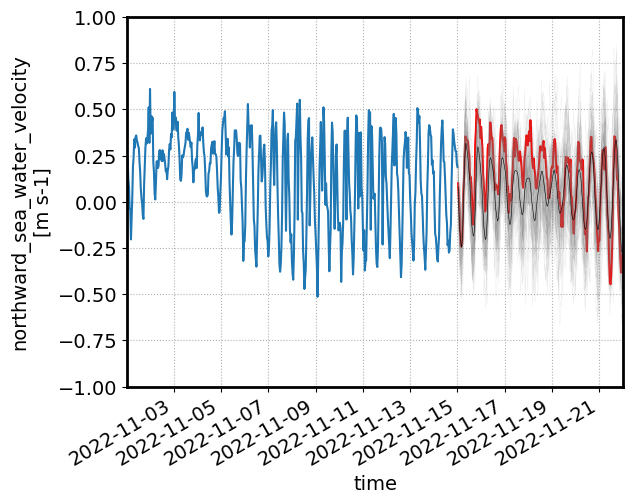

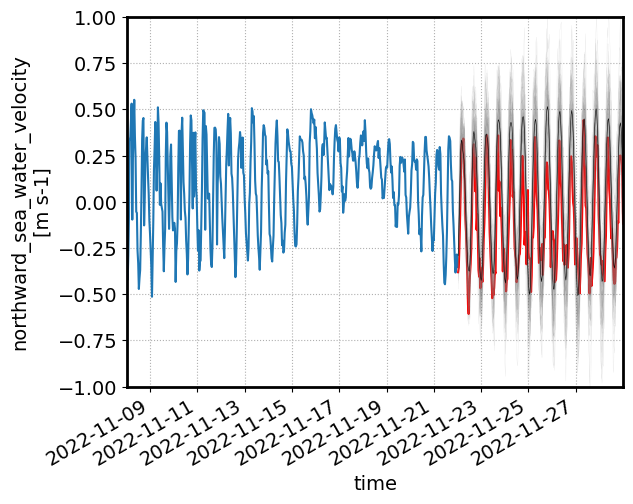

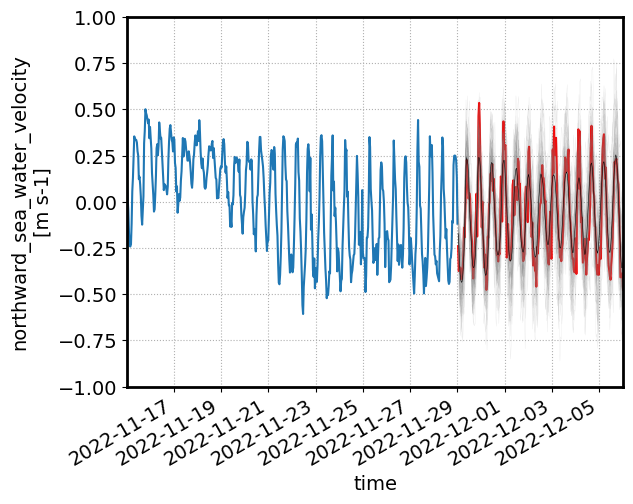

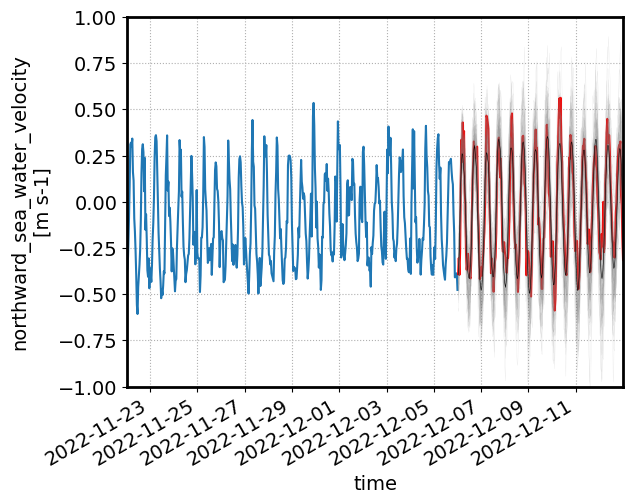

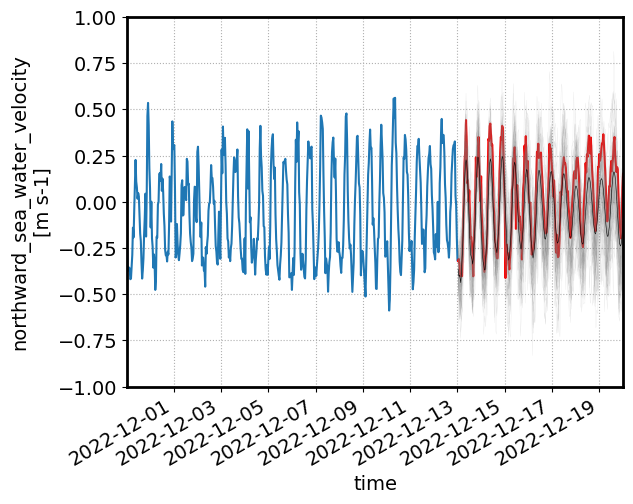

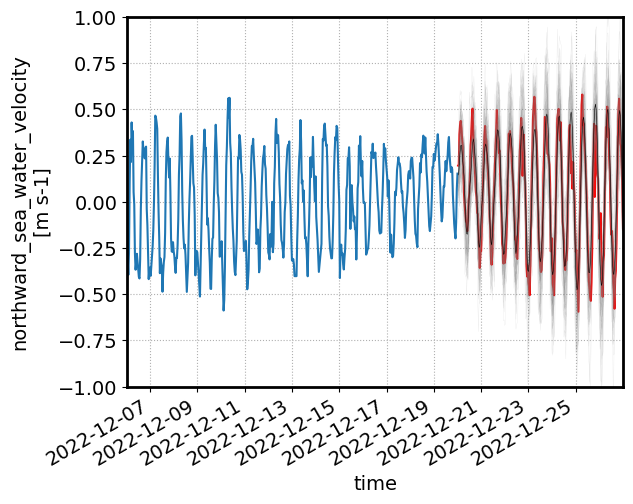

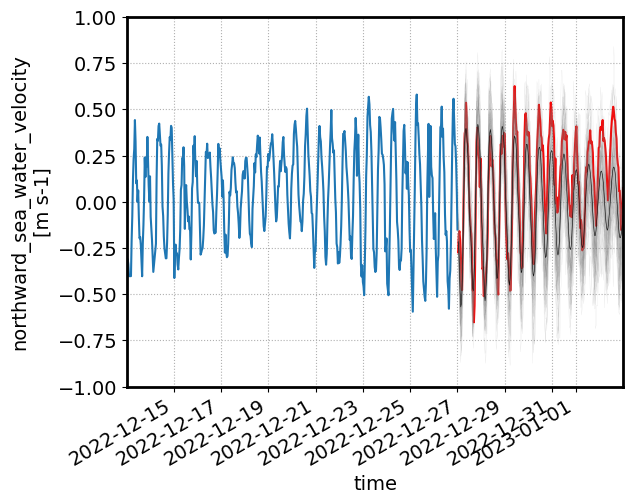

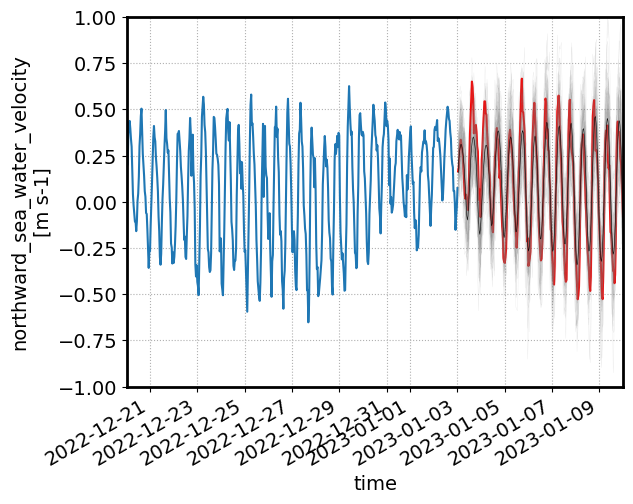

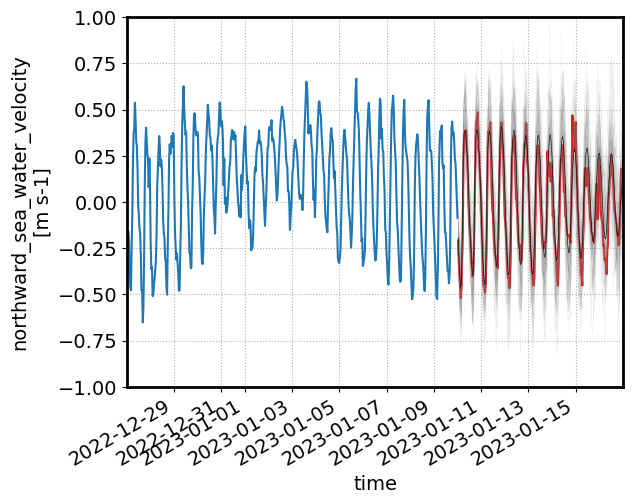

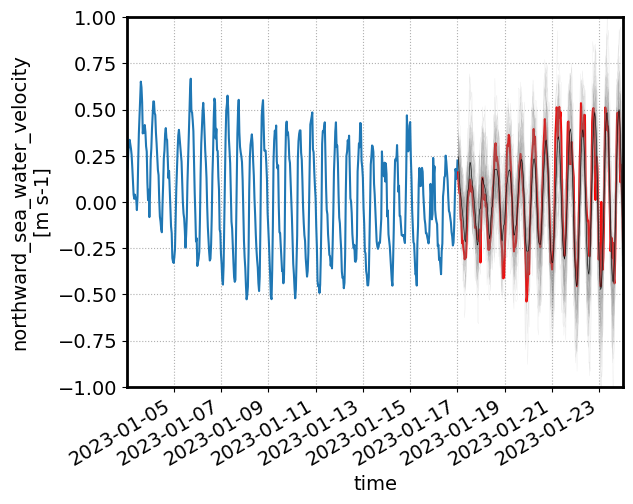

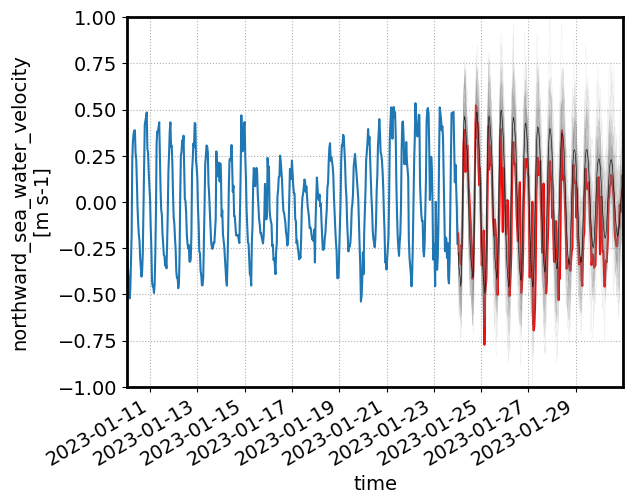

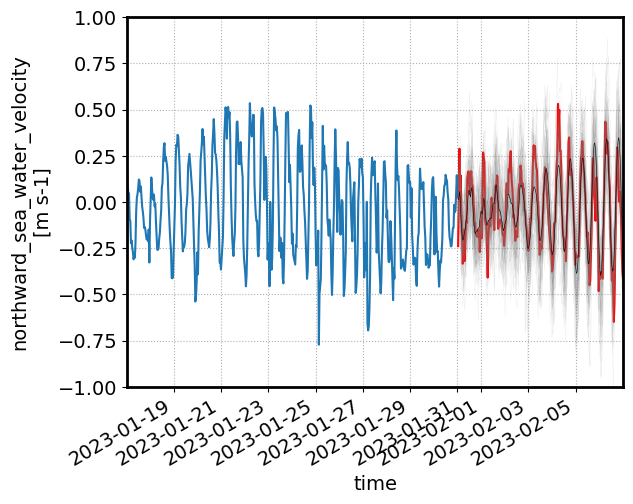

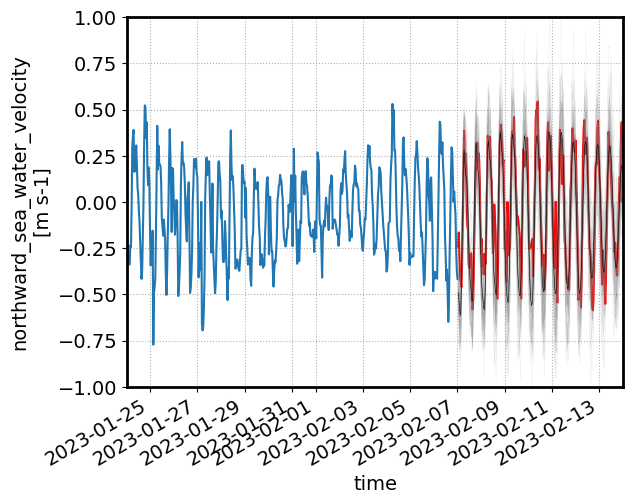

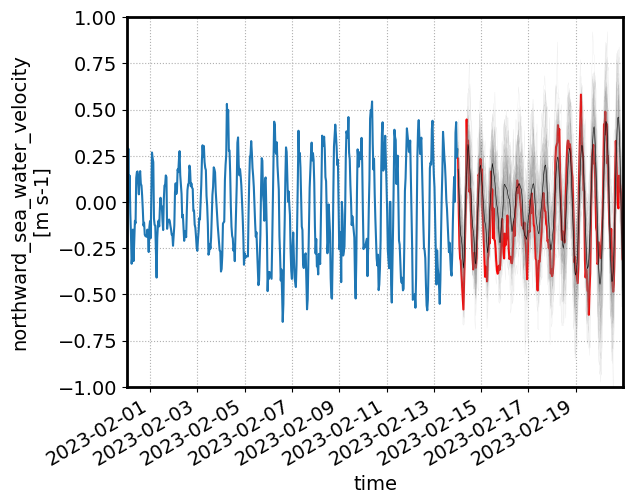

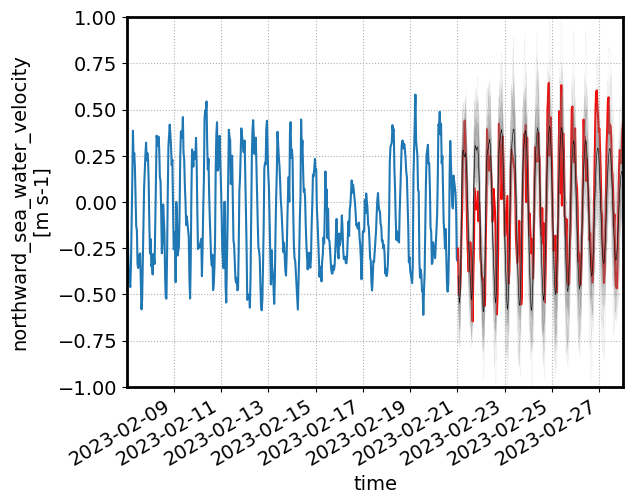

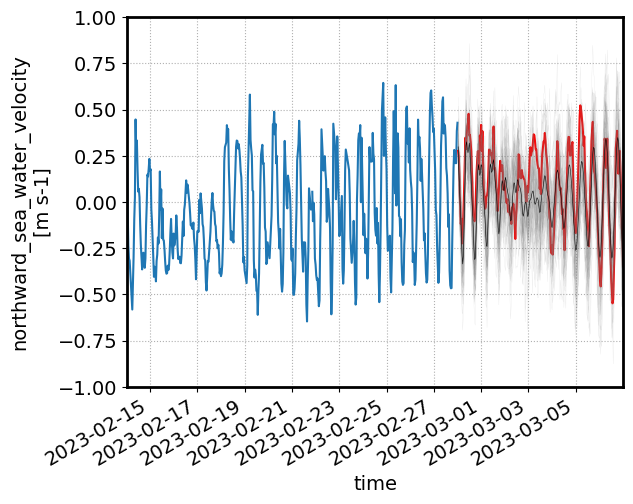

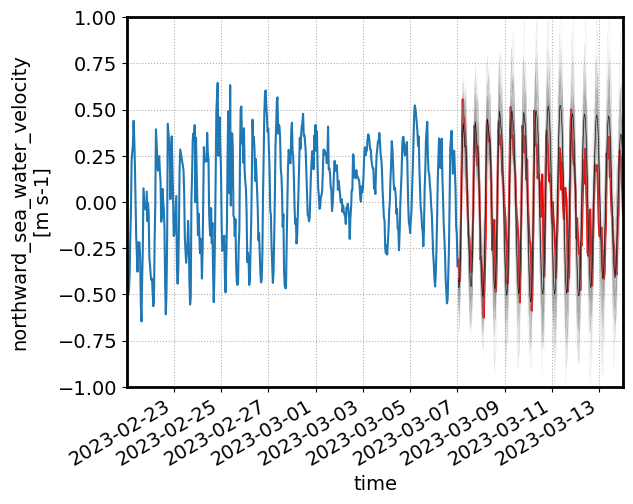

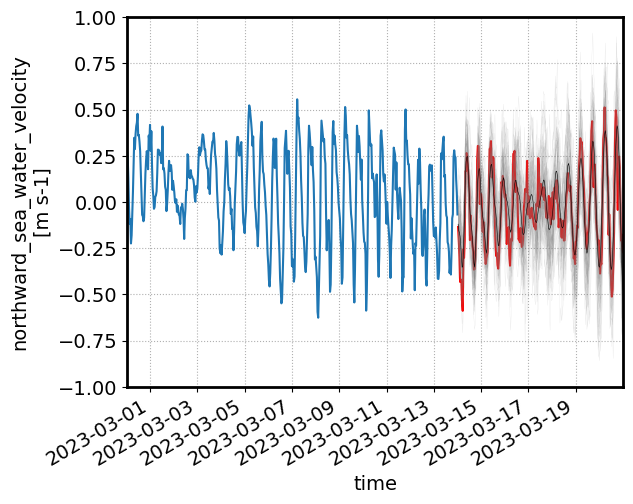

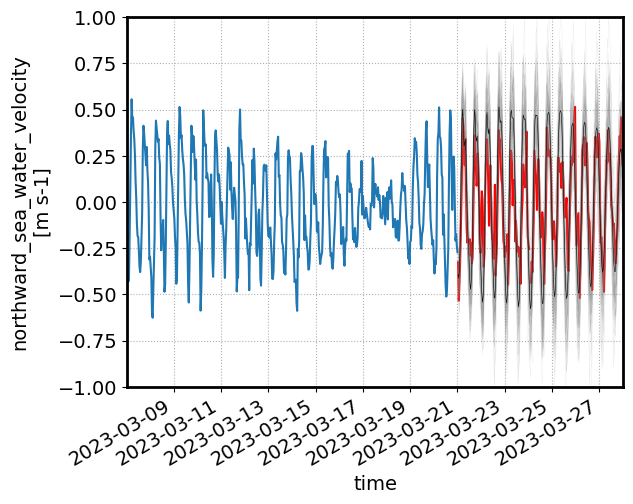

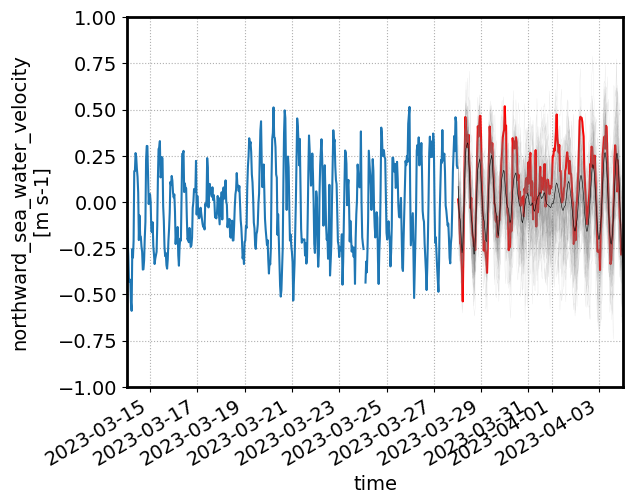

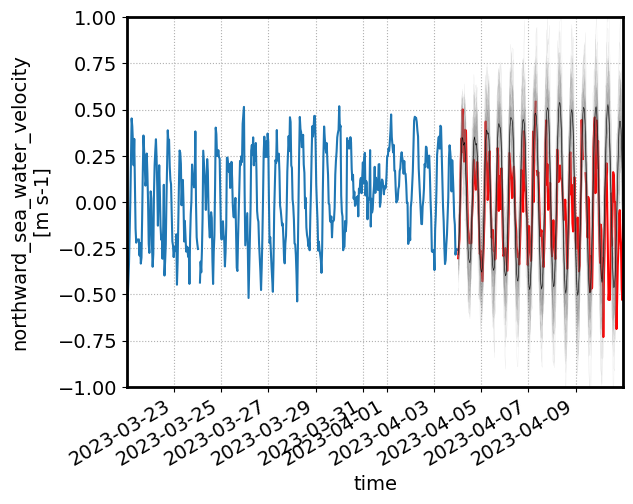

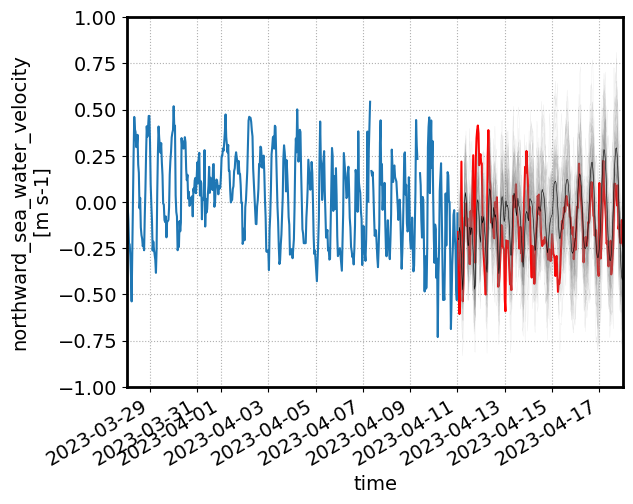

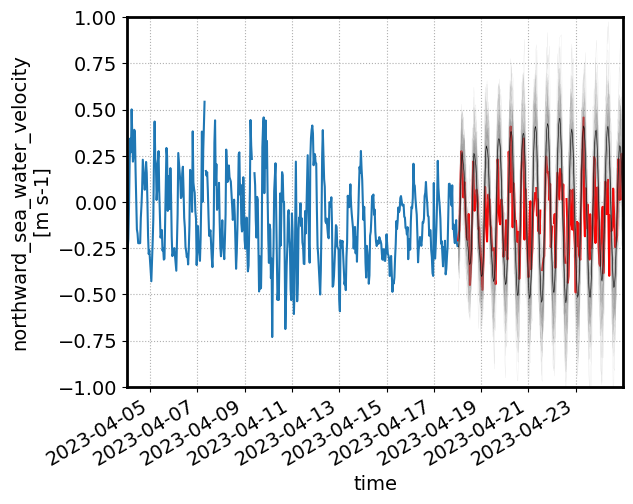

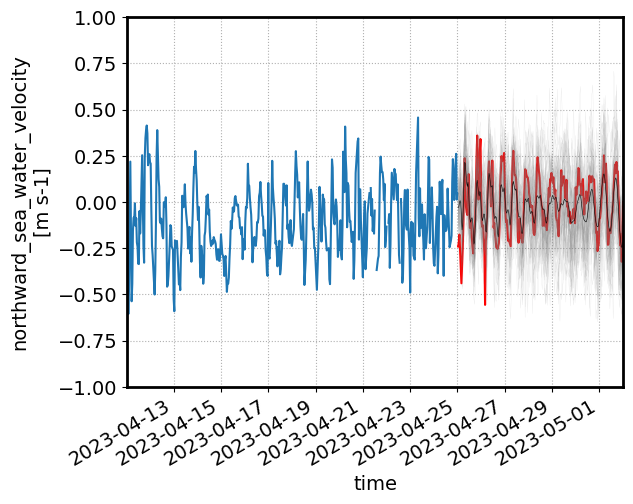

In [37]:
noise = 0.01 # Guess
covparams = params
# covparams = covparams.at[0].set(0.0) # Wipe out mesoscale
meanfunc = harmonic_mean_tmd
meanparams =np.hstack([ha['h_real'].values,ha['h_imag'].values])
mean_kwargs=dict(constituents=constituents)
nsamples = 50

crps_all = onp.zeros((M,N))
rmse_all = onp.zeros((M,N))
rmsemu_all = onp.zeros((M,N))

jj=-1
for  t1_train, t2_train in zip(start_times, end_times):
    jj+=1
    print(t1_train, t2_train)
    ds_train = ds2['VCUR'].sel(TIME=slice(t1_train, t2_train)).\
    isel(TIME=slice(None,None,1)) # Hourly data

    # Update the mean parameters ala Bertolacci/BCM 
    #fast_constituents = ['m2','s2']
    #meanparams_fast =calc_mean_params(ds_train, fast_constituents)
    #mean_kwargs=dict(constituents=fast_constituents)

    for ii, dt_forecast in enumerate(forecast_times):
        #print(t1_train, t2_train, dt_forecast)


        ds_test= ds2['VCUR'].sel(TIME=slice(t2_train, t2_train+dt_forecast)).\
            isel(TIME=slice(None,None,1)) # Hourly data

        GP, y_pred, y_cond, crps, rmse, rmse_mu = \
            calc_predictive_skill(ds_train, ds_test, 
                noise, 
                covfunc_gp,
                covparams,
                meanfunc, 
                meanparams,
                mean_kwargs,
                nsamples=100)

        crps_all[jj,ii] = crps
        rmse_all[jj,ii] = rmse
        rmsemu_all[jj,ii] = rmse_mu

    plot_conditional(ds_train, ds_test, GP, y_pred, y_cond)
    #break

In [38]:
ds_scores = xr.Dataset(
        None,
        coords=dict(
            time=("time", end_times), 
            forecast_time=("forecast_time", forecast_times)
        ),
    )
ds_scores["crps"] = (("time", "forecast_time"), crps_all)
ds_scores["rmse"] = (("time", "forecast_time"), rmse_all)
ds_scores["rmse_mu"] = (("time", "forecast_time"), rmsemu_all)

/tmp/ipykernel_284937/1195765459.py:1: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds_scores = xr.Dataset(


In [39]:
ds_scores

<xarray.Dataset>
Dimensions:        (time: 24, forecast_time: 6)
Coordinates:
  * time           (time) datetime64[ns] 2022-11-15 2022-11-22 ... 2023-04-25
  * forecast_time  (forecast_time) timedelta64[ns] 0 days 12:00:00 ... 7 days
Data variables:
    crps           (time, forecast_time) float64 0.04027 0.08334 ... 0.06768
    rmse           (time, forecast_time) float64 0.05599 0.1455 ... 0.1088
    rmse_mu        (time, forecast_time) float64 0.1299 0.2105 ... 0.09624

<Figure size 640x480 with 0 Axes>

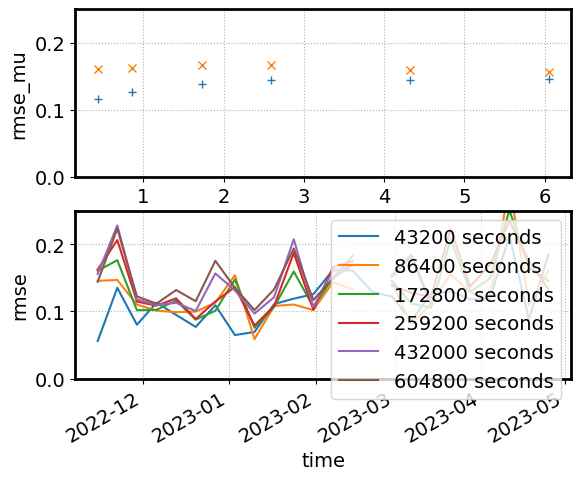

In [40]:
plt.figure()
plt.figure()
ax=plt.subplot(211)

ds_scores['rmse'].mean(axis=0).plot(marker='+',linestyle='', ax=ax)
ds_scores['rmse_mu'].mean(axis=0).plot(marker='x',linestyle='', ax=ax)

ax.set_ylim(0, 0.25)
ax.grid(True, ls=':')

ax2=plt.subplot(212)
for ii,_ in enumerate(forecast_times):
    ds_scores['rmse'].isel(forecast_time=ii).plot(ax=ax2)

plt.legend(forecast_times)
plt.title('')
plt.ylim(0, 0.25)
plt.grid(True, ls=':')

(0.0, 0.25)

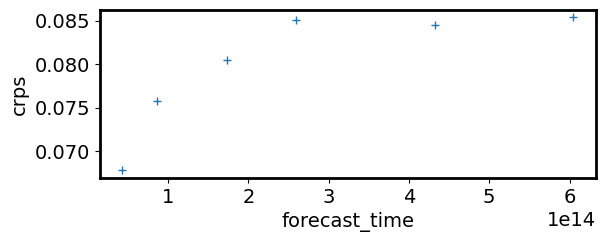

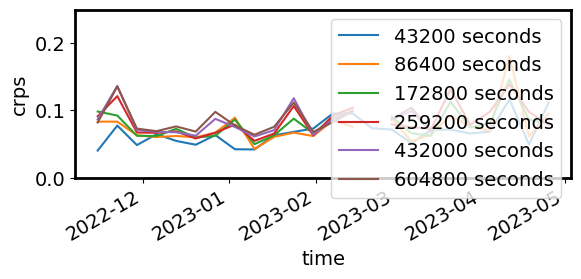

In [41]:
plt.figure()
ax=plt.subplot(211)
plt.figure()
ds_scores['crps'].mean(axis=0).plot(marker='+',linestyle='', ax=ax)
# ax.set_ylim(0, 0.25)

ax2=plt.subplot(212)
for ii,_ in enumerate(forecast_times):
    ds_scores['crps'].isel(forecast_time=ii).plot(ax=ax2)

plt.legend(forecast_times)
plt.title('')
plt.ylim(0, 0.25)